# Credit Card Fraud

Develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

raw_data = pd.read_csv('./data/creditcard.csv')
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

In [2]:
frauds_count = raw_data.groupby('Class').count()[raw_data.columns[0]].iloc[1]
okay_count = raw_data.groupby('Class').count()[raw_data.columns[0]].iloc[0]

baseline = 1 - frauds_count / (frauds_count + okay_count)
print('Frauds:', frauds_count)
print('Not Frauds:', okay_count)
print('Baseline R-squared:', baseline)

Frauds: 492
Not Frauds: 284315
Baseline R-squared: 0.9982725143693799


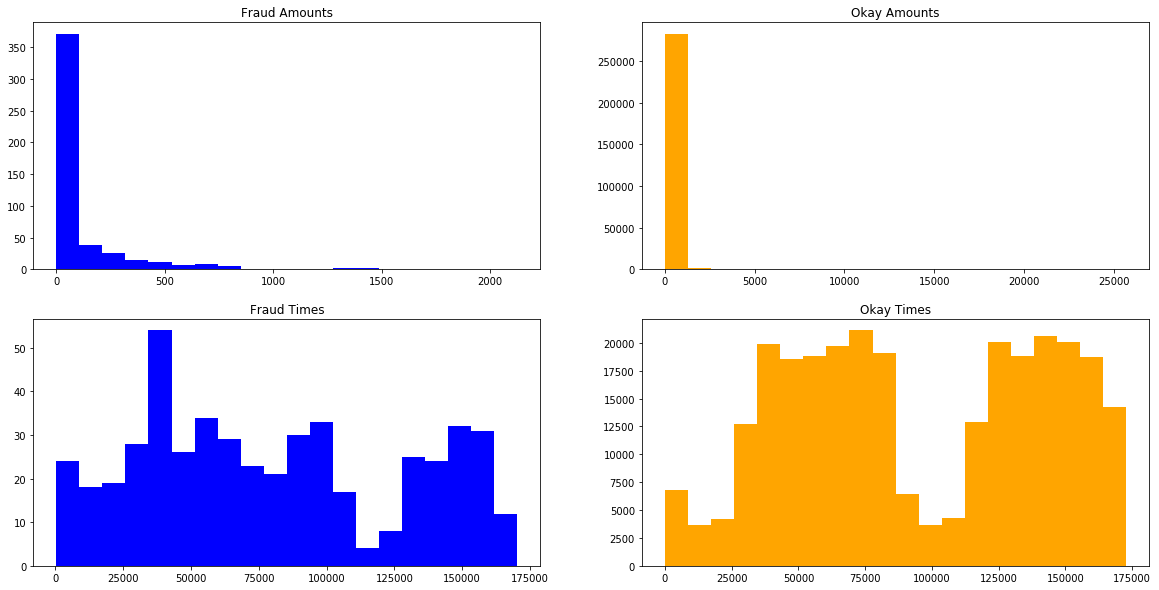

In [3]:
frauds = raw_data[raw_data['Class'] == 1]
okays = raw_data[raw_data['Class'] == 0]

plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
plt.title('Fraud Amounts')
plt.hist(frauds['Amount'], bins=20, label='Fraud', color='blue')

plt.subplot(2, 2, 2)
plt.title('Okay Amounts')
plt.hist(okays['Amount'], bins=20, label='Okay', color='orange')

plt.subplot(2, 2, 3)
plt.title('Fraud Times')
plt.hist(frauds['Time'], bins=20, label='Fraud', color='blue')

plt.subplot(2, 2, 4)
plt.title('Okay Times')
plt.hist(okays['Time'], bins=20, label='Okay', color='orange')

plt.show()

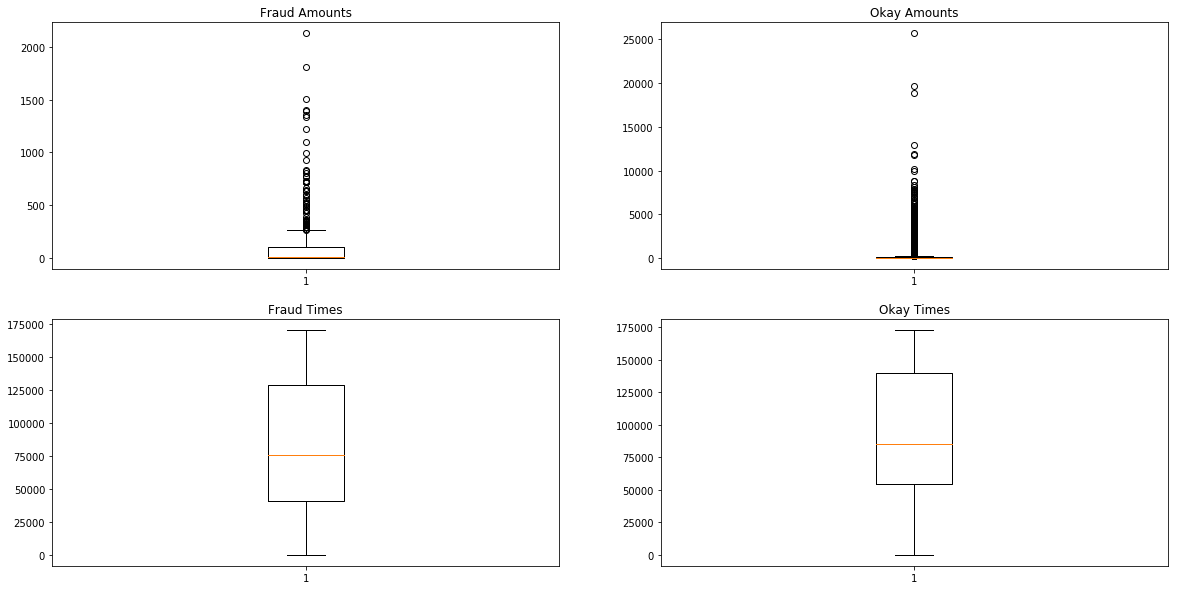

In [4]:
# TODO: 
# Try taking out outliers – see distribution of remaining amounts
# Compare model with / without outliers

plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
plt.title('Fraud Amounts')
plt.boxplot(frauds['Amount'])

plt.subplot(2, 2, 2)
plt.title('Okay Amounts')
plt.boxplot(okays['Amount'])

plt.subplot(2, 2, 3)
plt.title('Fraud Times')
plt.boxplot(frauds['Time'])

plt.subplot(2, 2, 4)
plt.title('Okay Times')
plt.boxplot(okays['Time'])

plt.show()

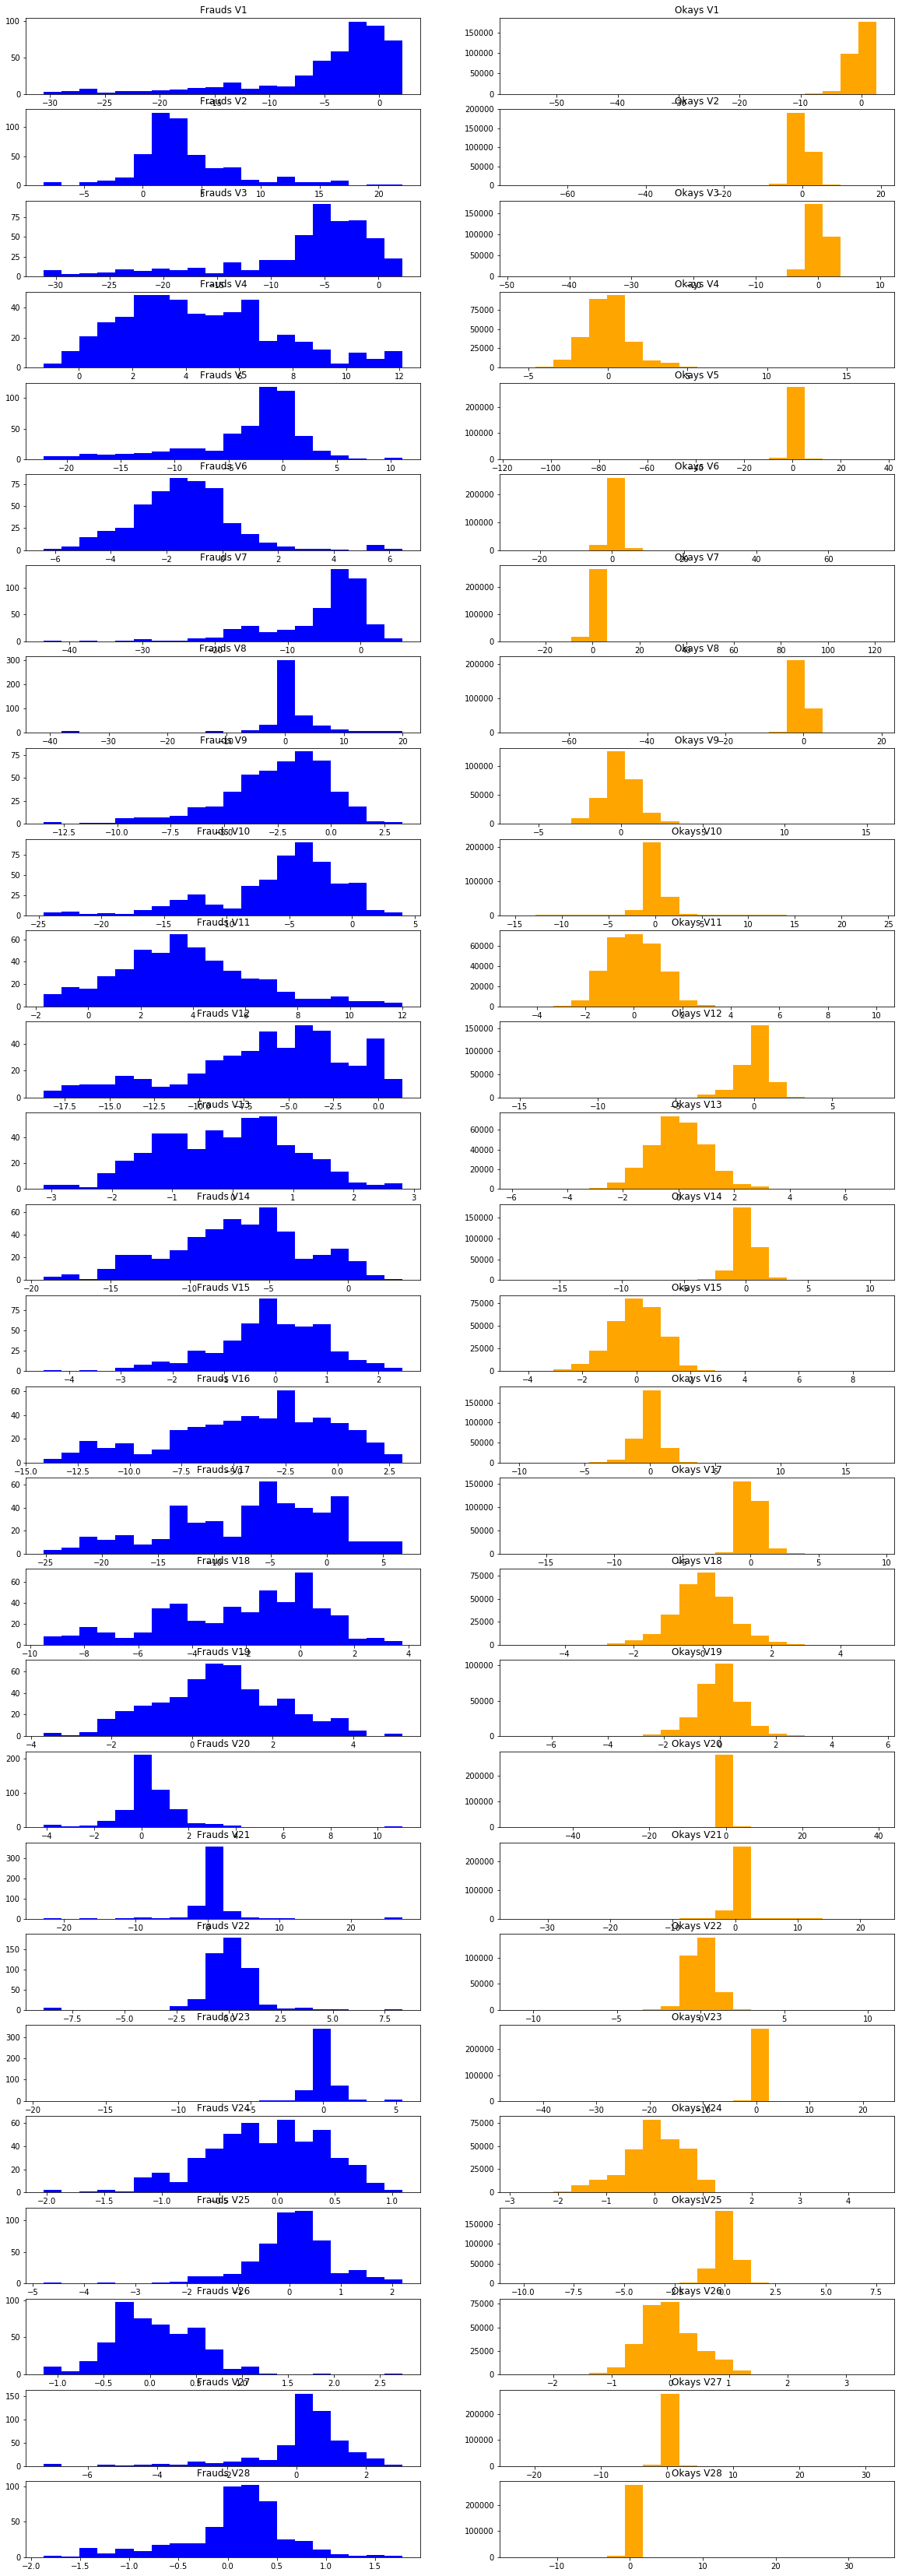

In [5]:
plt.figure(figsize=(20,60))

for i in range(28):
    col_name = 'V' + str(i + 1)
    
    plt.subplot(28, 2, 2 * i + 1)
    plt.title('Frauds ' + col_name)
    plt.hist(frauds[col_name], bins=20, color='blue')
    
    plt.subplot(28, 2, 2 * i + 2)
    plt.title('Okays ' + col_name)
    plt.hist(okays[col_name], bins=20, color='orange')
    
plt.show()

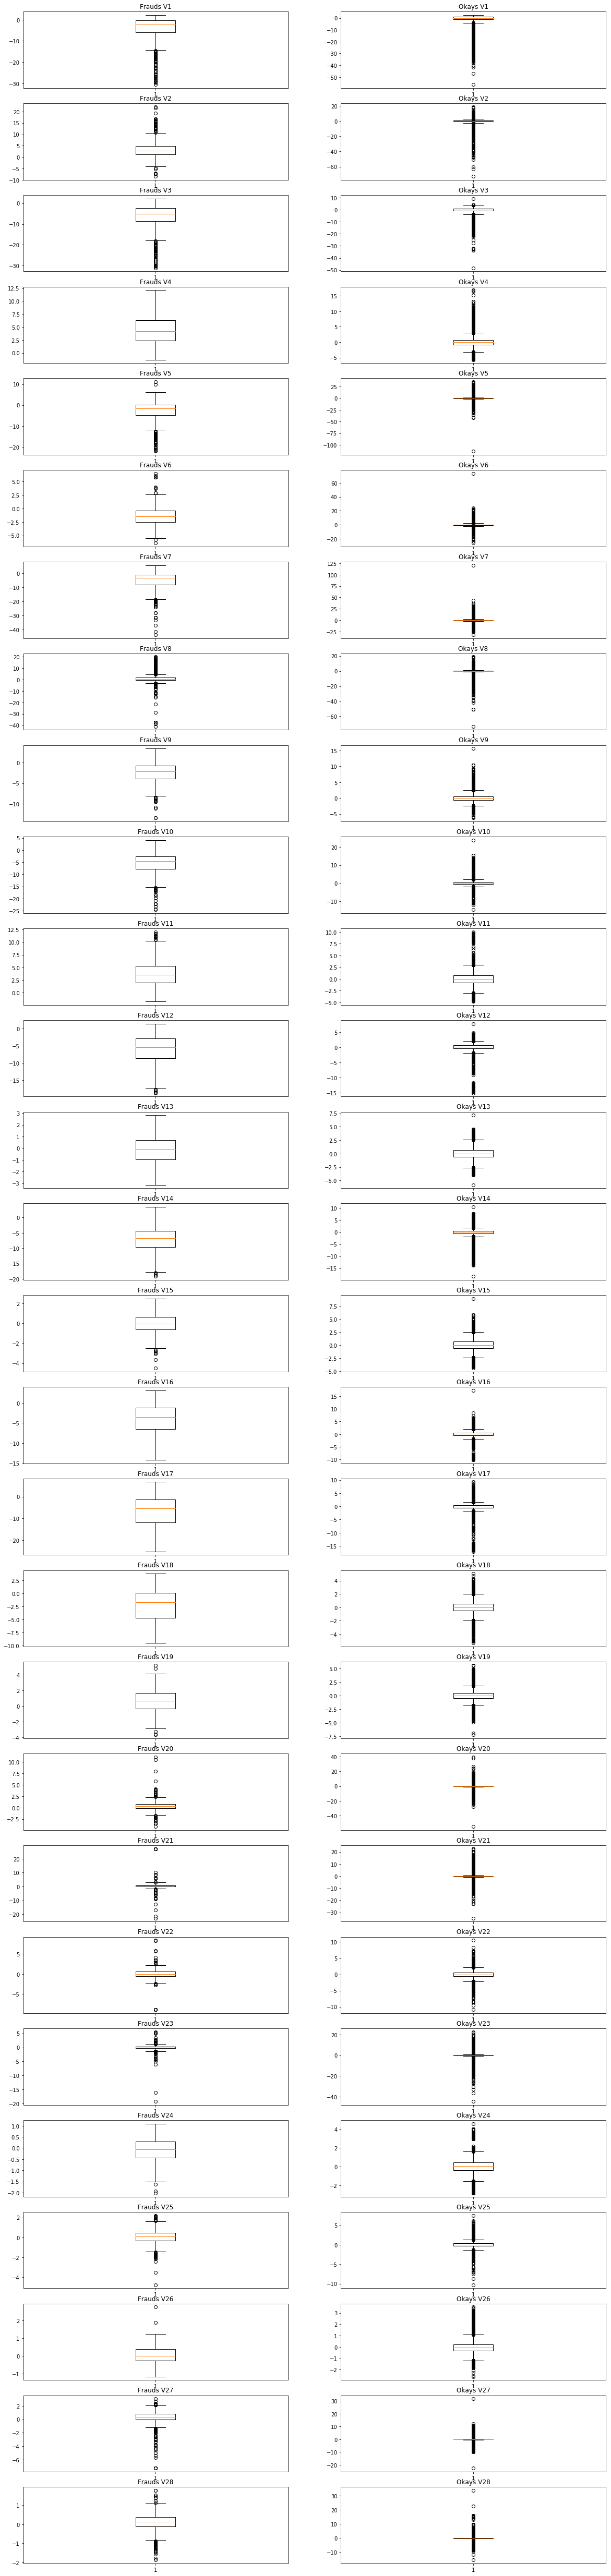

In [6]:
plt.figure(figsize=(20,90))

for i in range(28):
    col_name = 'V' + str(i + 1)
    
    plt.subplot(28, 2, 2 * i + 1)
    plt.title('Frauds ' + col_name)
    plt.boxplot(frauds[col_name])
    
    plt.subplot(28, 2, 2 * i + 2)
    plt.title('Okays ' + col_name)
    plt.boxplot(okays[col_name])
    
plt.show()

I am looking to minimize Type II errors ("false negative"s – i.e. considering something that is a fraud as okay). But before I begin to build models, I need to make sure my data is not skewed. There are 2 methods to correct this – undersampling my majority group (not-frauds) or oversampling my minority group (frauds). 

## STRATEGY 1: Undersampling Not-Frauds to Predict Frauds

In [7]:
print('Will randomly sample', frauds_count, '(# of frauds) random rows from "not-frauds" table')
undersampled_okays = okays.sample(n=frauds_count)
df = pd.concat([frauds, undersampled_okays])
df = df.reset_index()
df.head()

Will randomly sample 492 (# of frauds) random rows from "not-frauds" table


,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [8]:
df_test = df.iloc[::2]
df_train = df.iloc[1::2]

# TRAINING
X_train = df_train.loc[:, ~(df_train.columns).isin(['Class'])]
Y_train = df_train['Class'].values.reshape(-1, 1)

# TESTING
X_test = df_test.loc[:, ~(df_train.columns).isin(['Class'])]
Y_test = df_test['Class'].values.reshape(-1, 1)

### LASSO Logistic Regression

In [9]:
def fit_and_train(model, fit_X_train, fit_Y_train, X_train, Y_train):
    model_fit = model.fit(fit_X_train, fit_Y_train)
    model_score_train = model.score(X_train, Y_train)
    print('R² for train:', model_score_train)
    
    model_score_test = model.score(X_test, Y_test)
    print('\nR² for test:', model_score_test)
    
    model_improve_over_baseline = (model_score_test - baseline) / baseline
    print('Improvement over baseline:', model_improve_over_baseline)
    
    if hasattr(model_fit, 'coef_'):
        print('\nCoefficients:', model_fit.coef_)
    
    if hasattr(model_fit, 'intercept_'):
        print('\nIntercept:', model_fit.intercept_)
    
    if hasattr(X_train, 'columns'):
        print('Data cols:', list(X_train.columns))

lasso = linear_model.LogisticRegression(penalty='l1', C=100) 
fit_and_train(lasso, X_train, Y_train, X_train, Y_train)

R² for train: 0.9410569105691057

R² for test: 0.959349593495935
Improvement over baseline: -0.03899027601499477

Coefficients: [[ 5.89147914e-05 -1.10362879e-04  1.93683928e+00  4.13155475e+00
   7.95204335e-01  7.44384895e-01  2.37974455e+00 -1.72740557e+00
  -4.17113734e+00  3.58128678e-01 -5.23313060e-01 -1.44306075e+00
   1.79882890e+00 -3.60657970e+00 -3.89914854e-01 -4.52547209e+00
  -5.67961294e-02 -2.90924361e+00 -4.97943334e+00 -2.03379453e+00
   1.76068830e+00 -3.54507435e+00 -1.93043234e-01  1.91496960e+00
   2.74851844e+00 -2.47637324e-01  1.60120645e+00  3.44595720e-01
  -1.41367370e-02  4.41860043e+00  4.07749748e-02]]

Intercept: [-5.3024466]
Data cols: ['index', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Evaluating LASSO Logistic Regression

In [10]:
def evaluate_model_printout(model):
    Y_train_vals = df_train['Class'].values
    Y_test_vals = df_test['Class'].values

    predict_train = model.predict_proba(X_train)
    predict_train = list(map(lambda x: 0 if x[0] > .998 else 1, predict_train))
    predict_train = np.fromiter(predict_train, dtype=np.int)

    predict_test = model.predict_proba(X_test)
    predict_test = list(map(lambda x: 0 if x[0] > .998 else 1, predict_test))
    predict_test = np.fromiter(predict_test, dtype=np.int)
    
    crosstab_labels = [0, 1, 'All']
    table_train = pd.crosstab(Y_train_vals, predict_train, rownames=['actual'], colnames=['predicted'], margins=True)
    table_train = table_train.reindex(index=crosstab_labels,columns=crosstab_labels, fill_value=0)

    print('TRAIN:')
    print(table_train, '\n')

    train_tI_errors = table_train.loc[0,1] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1,0] / table_train.loc['All','All']
    print(('Accuracy:\n% Type I errors: {}\n% Type II errors: {}\n').format(train_tI_errors, train_tII_errors))

    train_precision = table_train.loc[1,1] / table_train.loc['All', 1] # correctly predicted positives / all predicted positives
    train_recall = table_train.loc[1,1] / table_train.loc[1,'All'] # true positives / (true positives + false negatives)
    print('Precision:', train_precision)
    print('Recall:', train_recall, '\n\n----------\n')

    table_test = pd.crosstab(Y_test_vals, predict_test, rownames=['actual'], colnames=['predicted'], margins=True)
    table_test = table_test.reindex(index=crosstab_labels,columns=crosstab_labels, fill_value=0)
    
    print('TEST:')
    print(table_test, '\n')

    test_tI_errors = table_test.loc[0,1]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1,0]/table_test.loc['All','All']
    print(('Accuracy:\n% Type I errors: {}\n% Type II errors: {}\n').format(test_tI_errors, test_tII_errors))

    test_precision = table_test.loc[1,1] / table_test.loc['All', 1] # correctly predicted positives / all predicted positives
    test_recall = table_test.loc[1,1] / table_test.loc[1,'All'] # true positives / (true positives + false negatives)
    print('Precision:', test_precision)
    print('Recall:', test_recall)

evaluate_model_printout(lasso)

TRAIN:
predicted   0    1  All
actual                 
0          33  213  246
1           0  246  246
All        33  459  492 

Accuracy:
% Type I errors: 0.4329268292682927
% Type II errors: 0.0

Precision: 0.5359477124183006
Recall: 1.0 

----------

TEST:
predicted   0    1  All
actual                 
0          33  213  246
1           0  246  246
All        33  459  492 

Accuracy:
% Type I errors: 0.4329268292682927
% Type II errors: 0.0

Precision: 0.5359477124183006
Recall: 1.0


I am looking to minimize Type II errors ("false negative"s – i.e. considering something that is a fraud as okay). My test set gave 0.0% for Type II errors, which I am very happy with, especially since my percentage of Type I errors is also extremely low (~0.000035%).

In [11]:
# NOTE: Could use ROC / AUC threshold for less performant classifiers

### Ridge Logistic Regression

In [12]:
ridge = linear_model.LogisticRegression(penalty='l2', C=100, fit_intercept=False)
fit_and_train(ridge, X_train, Y_train, X_train, Y_train)

R² for train: 0.9288617886178862

R² for test: 0.9471544715447154
Improvement over baseline: -0.051206501319888915

Coefficients: [[ 6.49290554e-05 -1.26188923e-04 -1.14253170e-02  7.72987248e-02
  -3.04716439e-01  6.14291363e-01  1.38872686e-01 -8.76809994e-02
  -8.32432150e-02 -1.93402404e-01 -9.77601971e-02 -2.54752354e-01
   1.26363520e-01 -3.26228755e-01 -8.77218302e-02 -6.14656434e-01
  -2.07286231e-02 -7.49064003e-02 -1.38637938e-02  5.90797498e-02
   5.05182964e-02 -4.53198568e-02  1.21184659e-01  1.37334002e-01
  -2.78408690e-02 -2.00140169e-02 -1.59378835e-02  2.55548306e-02
  -9.93700137e-05 -2.59489331e-03  1.50152845e-03]]

Intercept: 0.0
Data cols: ['index', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


I am less happy with the ridge regression's R² value here, as it is only a 0.04% improvement on baseline.

#### Evaluating Ridge Logistic Regression

In [13]:
evaluate_model_printout(ridge)

TRAIN:
predicted  0    1  All
actual                
0          0  246  246
1          0  246  246
All        0  492  492 

Accuracy:
% Type I errors: 0.5
% Type II errors: 0.0

Precision: 0.5
Recall: 1.0 

----------

TEST:
predicted  0    1  All
actual                
0          1  245  246
1          0  246  246
All        1  491  492 

Accuracy:
% Type I errors: 0.49796747967479676
% Type II errors: 0.0

Precision: 0.5010183299389002
Recall: 1.0


### Gradient Boosting Classifier

In [14]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, loss='deviance')
fit_and_train(gbm, X_train, Y_train, X_train, Y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R² for train: 1.0

R² for test: 0.943089430894309
Improvement over baseline: -0.05527857642152026
Data cols: ['index', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


#### Evaluating Gradient Boosting Classifier

In [15]:
evaluate_model_printout(gbm)

TRAIN:
predicted    0    1  All
actual                  
0          173   73  246
1            0  246  246
All        173  319  492 

Accuracy:
% Type I errors: 0.1483739837398374
% Type II errors: 0.0

Precision: 0.7711598746081505
Recall: 1.0 

----------

TEST:
predicted    0    1  All
actual                  
0          141  105  246
1            2  244  246
All        143  349  492 

Accuracy:
% Type I errors: 0.21341463414634146
% Type II errors: 0.0040650406504065045

Precision: 0.6991404011461319
Recall: 0.991869918699187


### Support Vector Machine

In [16]:
svm = SVC(kernel='linear', probability=True)
fit_and_train(svm, X_train, Y_train, X_train, Y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R² for train: 0.8739837398373984

R² for test: 0.8638211382113821
Improvement over baseline: -0.1346840409033322

Coefficients: [[ 4.61950153e-02 -1.43059211e-01 -8.29970814e+01  1.23519150e+02
  -2.74039667e+02  2.99479037e+02 -3.14089833e+01 -8.95828458e+01
  -1.68924246e+02 -1.21628406e+01 -1.14478096e+02 -2.61927862e+02
   2.07943419e+02 -3.23561584e+02 -6.18082852e+00 -4.48193170e+02
  -9.27263528e+00 -1.59572359e+02 -2.10254487e+02 -3.87147649e+01
   3.83178798e+01  1.85843285e+01  3.52922128e+01  1.28468547e+01
   3.33214379e+00 -1.26357276e+01  5.96053854e+00  1.36798035e+01
   2.02791464e+01  3.78836695e+00  4.00723287e+00]]

Intercept: [-193.96881606]
Data cols: ['index', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


#### Evaluating Support Vector Machine

In [17]:
evaluate_model_printout(svm)

TRAIN:
predicted  0    1  All
actual                
0          0  246  246
1          0  246  246
All        0  492  492 

Accuracy:
% Type I errors: 0.5
% Type II errors: 0.0

Precision: 0.5
Recall: 1.0 

----------

TEST:
predicted  0    1  All
actual                
0          0  246  246
1          0  246  246
All        0  492  492 

Accuracy:
% Type I errors: 0.5
% Type II errors: 0.0

Precision: 0.5
Recall: 1.0


### Random Forest Classifier

In [18]:
rfc = ensemble.RandomForestClassifier()
fit_and_train(rfc, X_train, Y_train, X_train, Y_train)

R² for train: 0.9939024390243902

R² for test: 0.9410569105691057
Improvement over baseline: -0.05731461397233599
Data cols: ['index', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


#### Evaluating Random Forest Classifier

In [19]:
evaluate_model_printout(rfc)

TRAIN:
predicted    0    1  All
actual                  
0          157   89  246
1            0  246  246
All        157  335  492 

Accuracy:
% Type I errors: 0.18089430894308944
% Type II errors: 0.0

Precision: 0.7343283582089553
Recall: 1.0 

----------

TEST:
predicted    0    1  All
actual                  
0          111  135  246
1            3  243  246
All        114  378  492 

Accuracy:
% Type I errors: 0.27439024390243905
% Type II errors: 0.006097560975609756

Precision: 0.6428571428571429
Recall: 0.9878048780487805


### Naive Bayes

In [20]:
bnb = BernoulliNB()
fit_and_train(bnb, X_train, Y_train, X_train, Y_train)

R² for train: 0.9044715447154471

R² for test: 0.9085365853658537
Improvement over baseline: -0.08989121478538696

Coefficients: [[-0.00404041 -0.00404041 -1.56218503 -0.11526604 -2.46890631 -0.04115807
  -1.27932224 -1.82454929 -1.95808068 -0.33727901 -2.25533221 -2.42238629
  -0.07534944 -2.94847939 -0.725937   -2.74084002 -0.80389854 -1.75222863
  -1.54313683 -1.29392104 -0.3204719  -0.42583241 -0.24042919 -0.57895481
  -0.75983856 -0.76849662 -0.60815397 -0.65361634 -0.3204719  -0.35437345
  -0.04959694]]

Intercept: [-0.69314718]
Data cols: ['index', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Evaluating Naive Bayes

In [21]:
evaluate_model_printout(bnb)

TRAIN:
predicted    0    1  All
actual                  
0          185   61  246
1           14  232  246
All        199  293  492 

Accuracy:
% Type I errors: 0.12398373983739837
% Type II errors: 0.028455284552845527

Precision: 0.7918088737201365
Recall: 0.943089430894309 

----------

TEST:
predicted    0    1  All
actual                  
0          170   76  246
1           12  234  246
All        182  310  492 

Accuracy:
% Type I errors: 0.15447154471544716
% Type II errors: 0.024390243902439025

Precision: 0.7548387096774194
Recall: 0.9512195121951219


In [22]:
# PCA on models that work to reduce 
# Find out if multicollinearity using LASSO – remove features to improve

## STRATEGY 2: Over-Sampling Frauds

In [23]:
df_test = raw_data.iloc[::2]
df_train = raw_data.iloc[1::2]

X_train = df_train.loc[:, ~(df_train.columns).isin(['Class'])]
Y_train = df_train['Class'].values.reshape(-1, 1)

# TESTING
X_test = df_test.loc[:, ~(df_train.columns).isin(['Class'])]
Y_test = df_test['Class'].values.reshape(-1, 1)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### LASSO Logistic Regression

In [24]:
lasso = linear_model.LogisticRegression(penalty='l1', C=100) 
fit_and_train(lasso, X_train_res, Y_train_res, X_train, Y_train)

R² for train: 0.9921279748319909

R² for test: 0.9922333642313418
Improvement over baseline: -0.006049600736381217

Coefficients: [[-1.23974355e-05  4.32790984e-01  9.35296865e-02 -3.88997850e-01
   9.24080522e-01  1.42860869e-01 -3.79364705e-01 -4.65233247e-01
  -4.94909393e-01 -7.31079762e-01 -1.34940800e+00  6.71970661e-01
  -1.44476165e+00 -4.50118053e-01 -2.16686402e+00 -5.68310102e-02
  -1.24017613e+00 -2.05965489e+00 -7.12293554e-01  5.03077266e-01
  -1.44840836e-01  3.72242621e-01  4.08046056e-01  2.41186948e-01
  -5.08018764e-02 -2.86459284e-01 -1.59729034e-01  6.44470657e-01
   5.31494110e-01  2.01998685e-03]]

Intercept: [-3.35512482]
Data cols: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


#### Evaluating LASSO Logistic Regression

In [25]:
evaluate_model_printout(lasso)

TRAIN:
predicted      0       1     All
actual                          
0          15957  126205  142162
1              0     241     241
All        15957  126446  142403 

Accuracy:
% Type I errors: 0.8862523963680541
% Type II errors: 0.0

Precision: 0.0019059519478670736
Recall: 1.0 

----------

TEST:
predicted      0       1     All
actual                          
0          15982  126171  142153
1              1     250     251
All        15983  126421  142404 

Accuracy:
% Type I errors: 0.8860074155220359
% Type II errors: 7.022274655206314e-06

Precision: 0.0019775195576684254
Recall: 0.9960159362549801


### Ridge Logistic Regression

In [26]:
ridge = linear_model.LogisticRegression(penalty='l2', C=100, fit_intercept=False)
fit_and_train(ridge, X_train_res, Y_train_res, X_train, Y_train)

R² for train: 0.9842348826920782

R² for test: 0.9841366815538889
Improvement over baseline: -0.014160294520801055

Coefficients: [[-2.88144568e-05 -4.04504014e-02  1.12164514e-01 -5.35823088e-01
   3.52737003e-01  6.17133079e-02 -1.40504129e-01 -1.13339647e-01
  -1.21460170e-01 -1.51098455e-01 -2.98709346e-01  1.63780805e-01
  -3.08400817e-01 -8.33757391e-02 -6.06859385e-01 -8.20712552e-02
  -1.50759337e-01 -2.20943620e-01 -5.31105363e-03  9.85115532e-03
   2.13989897e-02  7.11540765e-02  4.45698722e-02  9.67376258e-03
  -2.30961743e-03 -4.26320315e-02 -4.13728660e-03  1.57466214e-02
   1.13830107e-02  3.41757805e-05]]

Intercept: 0.0
Data cols: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


#### Evaluating Ridge Logistic Regression

In [27]:
evaluate_model_printout(ridge)

TRAIN:
predicted   0       1     All
actual                       
0          46  142116  142162
1           0     241     241
All        46  142357  142403 

Accuracy:
% Type I errors: 0.9979845930212145
% Type II errors: 0.0

Precision: 0.0016929269372071623
Recall: 1.0 

----------

TEST:
predicted   0       1     All
actual                       
0          61  142092  142153
1           0     251     251
All        61  142343  142404 

Accuracy:
% Type I errors: 0.9978090503075756
% Type II errors: 0.0

Precision: 0.0017633462832735013
Recall: 1.0


### Gradient Boosting Classifier

In [28]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, loss='deviance')
fit_and_train(gbm, X_train_res, Y_train_res, X_train, Y_train)

R² for train: 0.9986166021783249

R² for test: 0.9980688744698183
Improvement over baseline: -0.00020399229331708759
Data cols: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


#### Evaluating Gradient Boosting Classifier

In [29]:
evaluate_model_printout(gbm)

TRAIN:
predicted      0      1     All
actual                         
0          80682  61480  142162
1              0    241     241
All        80682  61721  142403 

Accuracy:
% Type I errors: 0.4317324775461191
% Type II errors: 0.0

Precision: 0.003904667779199948
Recall: 1.0 

----------

TEST:
predicted      0      1     All
actual                         
0          80785  61368  142153
1             12    239     251
All        80797  61607  142404 

Accuracy:
% Type I errors: 0.4309429510407011
% Type II errors: 8.426729586247578e-05

Precision: 0.0038794292856331263
Recall: 0.952191235059761


### Support Vector Machine

In [ ]:
svm = SVC(kernel='linear', probability=True)
fit_and_train(svm, X_train_res, Y_train_res, X_train, Y_train)

#### Evaluating Support Vector Machine

In [ ]:
evaluate_model_printout(svm)

### Random Forest Classifier

In [ ]:
rfc = ensemble.RandomForestClassifier()
fit_and_train(rfc, X_train_res, Y_train_res, X_train, Y_train)

#### Evaluating Random Forest Classifier

In [ ]:
evaluate_model_printout(rfc)

### Naive Bayes

In [ ]:
bnb = BernoulliNB()
fit_and_train(bnb, X_train_res, Y_train_res, X_train, Y_train)

#### Evaluating Naive Bayes

In [ ]:
evaluate_model_printout(bnb)

## Conclusion

Of all the classifiers used, the Naive Bayes model was the most performant, as it 1) minimized errors, especially Type II errors, and 2) showed a high precision and recall rate.

In [ ]:
# MENTOR NOTES:
# Precision – % of my + predictions that are correct
# Recall – % of my target +s I predicted


# CURRICULUM NOTES:
# There are a few things you can do to deal with class imbalance:

# Ignore. If we really only care about the absolute accuracy of the model and our sample is representative of the population, 
# this can be a reasonable strategy. Engineer features that strongly identify the minority class, and this can turn out ok.

# Change your sampling. If you oversample the minority class or undersample the majority class, you can create a more balanced training set. 
# This is particularly useful if the goal of your model is to correctly identify the minority class. This can also be done by creating synthetic samples 
# to try to make your data more balanced or weighting samples to balance out your classes. 

# Probability outputs. 
# Although Naive Bayes' probability outputs are generally inaccurate, other models will give you a more accurate probability of a certain class. 
# e.g. logistic regression or support vector machines (SVM)
# Instead of just taking the most likely outcome, you can set up a specific cutoff or a more complex rule. 
# In the binary case, it could be going with the minority case if it has a priority greater than some threshold.

# Lastly, you can create cost functions for errors. This quantifies ways in which errors are not equal – scale the cost of an error up or down. 
# This can mean something like a Type II error being twice as bad as a Type I error, or however you choose to quantify that relationship. 
# SKLearn's Naive Bayes model does not have an easy built-in way to do this, but it's a good thing to keep in mind.